Goal
==
We are about to train a *sequence-to-sequence model* to predict a paragraph of Gustave Flaubert's *Madame Bovary* given the preceding paragraph.
The model (at least in its first version) does not use words as units of text but characters.

*   The encoder part, based on a bidirectional LSTM, reads an input paragraph and turns it into a set of tensors that serves as initial state for the decoder part.
*   The decoder part is based on an (unidirectional) LSTM. The state of the LSTM is used to compute a probability distribution over the alphabet (including space and punctuation marks) and is updated each time a character is predicted by the LSTM reading this character's embedding.
*   The goal is to get the best model. It is part of the job to define what this means. It is also part of the job to explain me how you get your best model.

This is an assignment.
==

*   Work in groups of two or three students.
*   Due date: December 12th (Monday), 23:59
*   Malus: -1 per day of delay.

Loading PyTorch is important.
==

In [ ]:
# Imports PyTorch.
import torch

Remarks:
==
*   Follow the instructions very carefully. Do not ignore any comment.
*   Comment your code (including the role of all functions and the type of their arguments). A piece of code not appropriately commented can be considered incorrect (irrespectively of whether it works or not).
*   Indicate the shape of each tensor that you define.
*   Document all the changes that you make. Any work that is not properly explained can be ignored.

Downloading the dataset
==
The dataset we are going to use is there: "https://www.gutenberg.org/cache/epub/14155/pg14155.txt"

We have to pre-process it a little bit in order to remove everything that is not part of the text and to split the actual text into paragraphs.

In [ ]:
# Downloads the dataset.
import urllib

#to train on french data change this variable to 'fr'
USER_LG = 'fr'

#to change between word and character tokenization, change this to 'word' or char'
TOKENIZATION = 'word'

tmp  =  urllib.request.urlretrieve('https://www.gutenberg.org/cache/epub/67138/pg67138.txt') if USER_LG == 'en' else\
        urllib.request.urlretrieve("https://www.gutenberg.org/cache/epub/14155/pg14155.txt")
filename = tmp[0]
print(filename)

/tmp/tmpr0exwptj


In [ ]:
# Prints the first 200 lines in the file with their line number.
# This shows that we have a little bit of preprocessing to do in order to clean the data.
with open(filename) as f:
  for i in range(20):
    print(f"[{i}] {f.readline()}", end='')

[0] ﻿The Project Gutenberg EBook of Madame Bovary, by Gustave Flaubert
[1] 
[2] This eBook is for the use of anyone anywhere at no cost and with
[3] almost no restrictions whatsoever.  You may copy it, give it away or
[4] re-use it under the terms of the Project Gutenberg License included
[5] with this eBook or online at www.gutenberg.org
[6] 
[7] 
[8] Title: Madame Bovary
[9] 
[10] Author: Gustave Flaubert
[11] 
[12] Release Date: November 26, 2004 [EBook #14155]
[13] [Last updated: November 28, 2011]
[14] 
[15] 
[16] Language: French
[17] 
[18] 
[19] *** START OF THIS PROJECT GUTENBERG EBOOK MADAME BOVARY ***


In [ ]:
import re # Regular expression library
roman_regex = re.compile('^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$') # This regular expression matches Roman numerals but also the empty string.

EOP = '\n' # The end-of-line character will be used to mark the end of paragraphs.
END_OF_BOOK = 'THE END' if USER_LG == 'en' else \
              'End of the Project Gutenberg EBook of Madame Bovary, by Gustave Flaubert'

with open(filename) as f:
  # We want to skip everything before the actual text of the novel.
  # The line "PREMIÈRE PARTIE" appears twice: in the table of content and then at the start of the first part of the actual text.
  # The following lines discard everything up to this second occurence (included).
  skip = 2
  while(skip > 0):
    line = f.readline().strip()
    # The two langauges have different preprocessing needs, but since they're in different langauge we don't need to worry about overlap
    if(line == "BOOK I"): skip -= 2
    if(line.startswith('PREMIÈRE PARTIE')): skip -=1 

  paragraphs = [] # Note that each dialog line will be considered a separate paragraph.
  paragraph_buffer = [] # List[str]; each element corresponds to a line in the original text file + an additonal space if necessary.
  while(True):
    line = f.readline().strip()
    if(line == "End of the Project Gutenberg EBook of Madame Bovary, by Gustave Flaubert"): break # End of the actual text (fr).
    if(line == END_OF_BOOK): break # End of the actual text (en).

    if(line == ""): # We've reached the end of a paragraph.
      if(len(paragraph_buffer) > 0):
        paragraph_buffer.append(EOP) # End of the paragraph.

        paragraph = "".join(paragraph_buffer) # The different lines that make up the paragraph are joined into a single string.
        paragraphs.append(paragraph)
        paragraph_buffer = []
      continue

    if(roman_regex.match(line)): continue # Ignores the lines that indicate the beginning of a chapter.
    if(line.endswith(" PARTIE") or line.startswith("CHAPTER") or line.startswith("BOOK") or len(line.strip()) == 1): continue # Ignores the lines that indicate the beginning of a part.

    if((len(paragraph_buffer) > 0) and (paragraph_buffer[-1][-1] != '-')): paragraph_buffer.append(' ') # Adds a space between consecutive lines except when the first one ends with "-" (e.g. if the word "pomme-de-terre" is split with "pomme-de-" at the end of a line and "terre" at the beginning of the next, we do not want to join the two lines with a space).
    paragraph_buffer.append(line)

print(f"{len(paragraphs)} paragraphs read.")
for i in range(3): print(paragraphs[i], end='')

2995 paragraphs read.
Nous étions à l'Étude, quand le Proviseur entra, suivi d'un nouveau habillé en bourgeois et d'un garçon de classe qui portait un grand pupitre. Ceux qui dormaient se réveillèrent, et chacun se leva comme surpris dans son travail.
Le Proviseur nous fit signe de nous rasseoir; puis, se tournant vers le maître d'études:
-- Monsieur Roger, lui dit-il à demi-voix, voici un élève que je vous recommande, il entre en cinquième. Si son travail et sa conduite sont méritoires, il passera dans les grands, où l'appelle son âge.


In [ ]:
import collections
import numpy as np

# Computes the frequency of all characters in the dataset.
char_counts = collections.defaultdict(int)
for paragraph in paragraphs:
  for char in paragraph: char_counts[char] += 1

print(f"{len(char_counts)} different characters found in the dataset.")
print(sorted(char_counts.items(), key=(lambda x: x[1]), reverse=True)) # Shows each character with its frequency, in decreasing frequency order.

94 different characters found in the dataset.
[(' ', 109336), ('e', 76369), ('a', 44997), ('s', 42972), ('t', 38893), ('i', 38322), ('n', 35099), ('r', 34314), ('l', 33711), ('u', 32914), ('o', 27415), ('d', 19187), ('c', 14786), ('m', 14638), ('p', 13790), (',', 12378), ('v', 8441), ('é', 8263), ("'", 7451), ('.', 6225), ('b', 5519), ('q', 5455), ('f', 5406), ('h', 5386), ('g', 4704), ('-', 4243), ('\n', 2995), ('à', 2722), ('x', 2057), ('j', 1728), ('è', 1644), ('y', 1619), ('!', 1512), ('E', 1477), (';', 1425), ('ê', 1188), ('L', 981), ('C', 945), ('I', 769), ('M', 743), ('z', 674), ('A', 543), ('?', 530), (':', 480), ('ç', 470), ('B', 427), ('â', 410), ('P', 394), ('î', 327), ('R', 319), ('D', 313), ('O', 301), ('S', 298), ('ô', 296), ('ù', 293), ('H', 270), ('û', 241), ('Q', 237), ('J', 233), ('T', 211), ('V', 181), ('N', 155), ('U', 122), ('«', 120), ('»', 112), ('À', 84), ('F', 84), ('Y', 80), ('_', 64), ('G', 62), ('(', 55), (')', 55), ('ï', 37), ('É', 25), ('k', 16), ('1', 16)

In [ ]:
# Here you have to build a dictionary 'char_vocabulary' that assigns an integer id to each character, along with a list/array 'id_to_char' that implements the reverse mapping.
#################
id_to_char = list({char for paragraph in paragraphs for char in paragraph})
char_vocabulary = {char:id for id, char in enumerate(id_to_char)}
#################

In [ ]:
EOP_id = char_vocabulary[EOP] # Id for the end-of-paragraph symbol

print(char_vocabulary)
print(id_to_char)
print(len(id_to_char))
print(f"EOP_id = {EOP_id}")

# Here you have to implement a test that proves that your implementations of 'char_vocabulary' and 'id_to_char' are consistent.
#################
# Test 1
# Checks whether every character in id_to_char is mapped to its index in char_vocabulary
for i in range(len(id_to_char)):
  assert char_vocabulary[id_to_char[i]] == i

# Test 2
# Checks whether a string can be encoded and decoded and not change
test = [char_vocabulary[char] for char in 'this is \na test']
print(test)
print(''.join([id_to_char[id] for id in test]))
for id, char in enumerate(id_to_char): 
  if char_vocabulary[char] != id: print(f'ERROR: {char} mapped to {id} and {char_vocabulary[char]}')
#################

{'E': 0, 'Î': 1, "'": 2, 'T': 3, '7': 4, 'p': 5, 'e': 6, 'Ç': 7, '4': 8, '0': 9, 'Ê': 10, ',': 11, 'ï': 12, '(': 13, 'A': 14, 'L': 15, 'o': 16, 'è': 17, 'g': 18, 'ç': 19, ' ': 20, '«': 21, 't': 22, 'r': 23, 'W': 24, '°': 25, 'G': 26, '8': 27, 'ê': 28, 'O': 29, 'J': 30, '2': 31, 'k': 32, 'R': 33, 'h': 34, 'c': 35, 'ë': 36, 'N': 37, ';': 38, 'a': 39, 'û': 40, 'D': 41, 'X': 42, 'U': 43, 'f': 44, 'P': 45, 'â': 46, ':': 47, 'É': 48, 'Q': 49, '1': 50, 'n': 51, 'ô': 52, 'j': 53, 'q': 54, '»': 55, 'I': 56, '\n': 57, 'ü': 58, 'd': 59, 'V': 60, 'b': 61, 'y': 62, 'z': 63, 'M': 64, 'À': 65, 'v': 66, 'é': 67, 'C': 68, 'B': 69, '3': 70, 'w': 71, 'à': 72, ')': 73, '.': 74, '6': 75, 'i': 76, 'm': 77, '5': 78, 'ù': 79, 's': 80, 'H': 81, '-': 82, 'î': 83, 'u': 84, 'F': 85, 'Y': 86, '_': 87, 'S': 88, '?': 89, 'l': 90, '9': 91, 'x': 92, '!': 93}
['E', 'Î', "'", 'T', '7', 'p', 'e', 'Ç', '4', '0', 'Ê', ',', 'ï', '(', 'A', 'L', 'o', 'è', 'g', 'ç', ' ', '«', 't', 'r', 'W', '°', 'G', '8', 'ê', 'O', 'J', '2', '

In [ ]:
# Turns a list of lists of ids into a list of strings.
# Do not forget that an occurrence of EOP means that the paragraph ends here.
def ids_to_texts(ids, decoding_map, end_tok_id, word_tokens = False):
  # Here you have to turn each list of character ids of 'ids' into a string and then return all strings as a list.
  # the decoding map maps integer ids to tokens 
  # word_tokens is a boolean indicating whether we are using words or characters
  # end_tok_id is the id of the token that marks the end of a paragraph
  #################
  decoded_strings = []
  join_string = ' ' if word_tokens else ''

  for sequence in ids:
    if isinstance(sequence, torch.Tensor): sequence = sequence.tolist() 
    if end_tok_id in sequence: sequence = sequence[:sequence.index(end_tok_id)]
    decoded_strings.append(join_string.join([decoding_map[tok] for tok in sequence]).strip())

  return decoded_strings
  #return[join_string.join([decoding_map[tok] for tok in paragraph]) for paragraph in ids]
  
  #################

In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
print(ids)
print(ids_to_texts(ids, id_to_char, EOP_id))
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids, id_to_char, EOP_id) == ps}")

[[69, 16, 51, 53, 16, 84, 23, 74], [68, 16, 77, 77, 6, 51, 22, 20, 39, 90, 90, 6, 63, 20, 66, 16, 84, 80, 20, 89]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids) == ps' should be True: True


In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
ids[0].extend([EOP_id, (EOP_id+1), (EOP_id+1)]) # With the end-of-paragraph token id and additional (padding-like) stuff for the first string.
print(ids)
print(ids_to_texts(ids, id_to_char, EOP_id))
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids, id_to_char, EOP_id) == ps}")

[[69, 16, 51, 53, 16, 84, 23, 74, 57, 58, 58], [68, 16, 77, 77, 6, 51, 22, 20, 39, 90, 90, 6, 63, 20, 66, 16, 84, 80, 20, 89]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids) == ps' should be True: True


# Alternative tokenization: words

Alternatively, the corpus can be tokenized into words instead of characters. The choice between the two is done at the start of the notebook.

In [ ]:
#installing a preprocessor 
!pip install polyglot
!pip install pyicu
!pip install pycld2
!pip install morfessor

from polyglot.text import Text
from polyglot.detect.base import logger as polyglot_logger
polyglot_logger.setLevel("ERROR")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Computes the frequency of all words in the dataset.
word_counts = collections.defaultdict(int)
for paragraph in paragraphs:
  for word in Text(paragraph).words: word_counts[word] += 1


print(f"{len(word_counts)} different words found in the dataset.")
print(sorted(word_counts.items(), key=(lambda x: x[1]), reverse=True)[:10]) # Shows top 10 words, in decreasing frequency order.

# Building the word to id and vice versa 
id_to_word = list({word for paragraph in paragraphs for word in Text(paragraph).words})
word_vocabulary = {word:id for id, word in enumerate(id_to_word)}

# Need to manually add unknown word token and stop token (\n is automatically removed by pretokenization for words)
word_vocabulary['<unk>'] = len(id_to_word)
id_to_word.append('<unk>')
word_vocabulary['EOP'] = len(id_to_word)
id_to_word.append('EOP')
word_EOP_id = word_vocabulary['EOP']

14770 different words found in the dataset.
[(',', 12378), ('.', 6225), ('de', 4396), ('-', 4243), ('la', 3237), ('et', 2525), ('à', 2337), ('le', 2172), ('les', 2157), ('des', 1611)]


In [ ]:
# Testing encoding and decoding 
test = [word_vocabulary[word] if word in id_to_word else word_vocabulary['<unk>'] for word in Text('this is \na test').words]
print(test)
print(' '.join([id_to_word[id] for id in test]))
for id, word in enumerate(id_to_word): 
  if word_vocabulary[word] != id: print(f'ERROR: {word} mapped to {id} and {word_vocabulary[word]}')


# Testing ids_to_text for word tokenization 
ps = ["Hello .", "How are you ?"] if USER_LG == 'en' else ["Bonjour .", "Comment allez vous ?"] 
ids = [[word_vocabulary[w] if w in id_to_word else word_vocabulary['<unk>'] for w in Text(p).words] for p in ps]
ids[0].extend([word_EOP_id, (word_EOP_id+1), (word_EOP_id+1)]) # With the end-of-paragraph token id and additional (padding-like) stuff for the first string.
print(ids)
print(word_EOP_id)
print(ids_to_texts(ids, id_to_word,word_EOP_id, word_tokens=True ))
print(ps)
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids, id_to_word,word_EOP_id, word_tokens=True) == ps}")

[14770, 13233, 4552, 14770]
<unk> is a <unk>
[[10784, 5809, 14771, 14772, 14772], [13787, 4396, 9999, 3289]]
14771
['Bonjour .', 'Comment allez vous ?']
['Bonjour .', 'Comment allez vous ?']
'ids_to_texts(ids) == ps' should be True: True


# Setting the tokenization strategy for the rest of the notebook

In [ ]:
# Sets everything according to the user's choice for tokenization strategy

if TOKENIZATION == 'char': 
  paragraphs    = paragraphs
  encoding_map  = char_vocabulary 
  decoding_map  = id_to_char
  END_id        = EOP_id
  word_tokens   = False

elif TOKENIZATION == 'word': 
  paragraphs    = [Text(paragraph+' EOP').words for paragraph in paragraphs]
  encoding_map  = word_vocabulary
  decoding_map  = id_to_word
  END_id        = word_EOP_id
  word_tokens   = True

else: 
  print('invalid tokenization, please check TOKENIZATION variable in cell 1')

Batch generator
==

In [ ]:
# Defines a class of objects that produce batches from the dataset.
# A training instance is composed of a pair of consecutive paragraphs. The goal will be to predict the second given the first.
# (Possible improvement: As is, ends of chapter are completely ignored: the last paragraph of a chapter and the first of the following chapter form a training instance. We might want to predict the end of the chapter instead, or simply remove these pairs from the dataset.)
class BatchGenerator:
  def __init__(self, paragraphs, vocabulary, test_size = .15):
    self.paragraphs = paragraphs
    self.vocabulary = vocabulary # Dictionary
    self.padding_idx = len(vocabulary)
    self.indices = np.arange(len(paragraphs)-1)

    self.splits = {}  # dictionary containing the indices of the examples in each split
    self._data_split(test_size)

  
  # Returns the number of training instances (i.e. of pairs of consecutive paragraphs).
  def length(self):
    return (len(self.paragraphs) - 1)

  def _data_split(self, test_size):
    '''
    Shuffles the indices and splits them into a train, dev and test set
    test_size: indicates the proportion of the data that should go in the test set (the same for the dev set)
    it is a float between 0. and 1.
    '''
    np.random.shuffle(self.indices)
    partition             = int(len(self.indices)*test_size)
    self.splits['test']   = self.indices[:partition]
    self.splits['dev']    = self.indices[partition:2*partition]
    self.splits['train']  = self.indices[2*partition:]

  # Returns a random training batch (composed of pairs of consecutive paragraphs).
  # We removed the `subset` option for this function, for debugging purposes, use a small dev or test set.
  def get_batch(self, batch_size, split = 'train'):
    # split: split to sample the batch from ('train', 'dev' or 'test', default='train')
    
    # Randomly picks some paragraph ids from the relevant split
    paragraph_ids = np.random.choice(self.splits[split], size=batch_size, replace = False) 

    return self._ids_to_batch(paragraph_ids)

  def _ids_to_batch(self, paragraph_ids):
    firsts = [] # First paragraph of each pair
    seconds = [] # Second paragraph of each pair
    for paragraph_id in paragraph_ids:
      firsts.append([self.vocabulary[char] for char in self.paragraphs[paragraph_id]])
      seconds.append([self.vocabulary[char] for char in self.paragraphs[paragraph_id + 1]])
      
    # Padding
    self.pad(firsts)
    self.pad(seconds)

    firsts = torch.tensor(firsts, dtype=torch.long) # Conversion to a tensor
    seconds = torch.tensor(seconds, dtype=torch.long) # Conversion to a tensor

    return (firsts, seconds)
  
  # Pads a list of lists (i.e. adds fake word ids so that all sequences in the batch have the same length, so that we can use a matrix to represent them).
  # In place
  def pad(self, sequences):
    max_length = max([len(s) for s in sequences])
    for s in sequences: s.extend([self.padding_idx] * (max_length - len(s)))
  
  # Returns a generator of training batches for a full epoch.
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful to debug the system.
  def all_batches(self, batch_size, subset=None, split = 'train'):
    # split: split to sample the batch from ('train', 'dev' or 'test', default='train')
    max_i = len(self.splits[split]) if(subset is None) else min(subset, len(self.splits[split]))

    # Loop that generates all full batches (batches of size 'batch_size').
    i = 0
    while((i + batch_size) <= max_i):
      instance_ids = self.splits[split][i:i+batch_size]
      yield self._ids_to_batch(instance_ids)
      i += batch_size
    
    # Possibly generates the last (not full) batch.
    if(i < max_i):
      instance_ids = self.splits[split][i:max_i]
      yield self._ids_to_batch(instance_ids)
  
  # Turns a list of arbitrary paragraphs into a prediction batch.
  def turn_into_batch(self, paragraphs):
    firsts = []
    for paragraph in paragraphs:
        # Unknown characters are ignored (removed).
        tmp = []
        for char in paragraph:
          if(char in self.vocabulary): tmp.append(self.vocabulary[char])

        if(tmp[-1] != EOP_id): tmp.append(EOP_id) # Adds an end-of-paragraph character if necessary.

        firsts.append(tmp)
    
    self.pad(firsts)
    return torch.tensor(firsts, dtype=torch.long)

batch_generator = BatchGenerator(paragraphs=paragraphs, vocabulary=encoding_map)
print(batch_generator.length())

2994


In [ ]:
(firsts, seconds) = batch_generator.get_batch(3)
print(ids_to_texts(firsts, decoding_map, END_id, word_tokens))
print(ids_to_texts(seconds, decoding_map, END_id, word_tokens))

["- - C'est extraordinaire ! c'est singulier ! répéta - t - il .", "Emma mit un châle sur ses épaules , ouvrit la fenêtre et s'accouda .", "Nous étions à l'Étude , quand le Proviseur entra , suivi d'un nouveau habillé en bourgeois et d'un garçon de classe qui portait un grand pupitre . Ceux qui dormaient se réveillèrent , et chacun se leva comme surpris dans son travail ."]
["Mais elle dit d'une voix forte :", "La nuit était noire . Quelques gouttes de pluie tombaient . Elle aspira le vent humide qui lui rafraîchissait les paupières . La musique du bal bourdonnait encore à ses oreilles , et elle faisait des efforts pour se tenir éveillée , afin de prolonger l'illusion de cette vie luxueuse qu'il lui faudrait tout à l'heure abandonner .", "Le Proviseur nous fit signe de nous rasseoir ; puis , se tournant vers le maître d'études :"]


The model
==
For this model, we will not define a `forward` method, but two methods: `trainingLogits` and `predictionStrings`.

*    `trainingLogits` is used at training time, when each batch is split in two parts: input paragraphs and output paragraphs. This function outputs, for each output paragraph of the batch, a log-probability distribution (i.e. a vector of "logits") before each token and after the last one. These distributions depend on the encoding of the corresponding input paragraph. They will then be used to compute a loss value.
*    `predictionStrings` is used at prediction time, when each batch is only composed of input paragraphs. This function outputs, for each input paragraph, a string obtained by decoding the encoding of the paragraph.

(Don't forget to read carefully all comments and to make sure that you understand them.)

In [ ]:
class Model(torch.nn.Module):
  # 'size_vocabulary' does not include a padding character, but does include the end-of-paragraph one.
  def __init__(self, size_vocabulary, EOP_id, embedding_dim, lstm_hidden_size, lstm_layers, device='cpu'):
    super().__init__()

    self.device = device

    self.EOP_id = EOP_id # At prediction time, this index is used to stop the generation at the end of the paragraph.

    # Here you have to define:
    #  (i) an embedding layer 'self.char_embeddings' with 'torch.nn.Embedding' for the characters, including an padding embedding;
    #  (ii) a bidirectional LSTM 'self.encoder_lstm' with a hidden size of 'lstm_hidden_size' and 'lstm_layers' layers (use batch_first=True);
    #  (iii) a unidirectional LSTM 'self.decoder_lstm' with a hidden size of 'lstm_hidden_size' and 'lstm_layers' layers (use batch_first=True);
    #  (iv) a network 'self.decoder_initialiser' meant to turn the final hidden and cell states of the encoder into the initial hidden and cell states of the decoder;
    #  (v) a network 'self.distribution_nn' meant to turn the hidden state of the decoder at each step into the logits of a probability distribution over the vocabulary. The logits of a probability distribution are simply the log-probabilities (you might want to use torch.nn.LogSoftmax).
    # Send all parts to 'device', so that we can use a GPU.
    #################
    self.size_vocabulary      = size_vocabulary

    # (i)
    self.char_embeddings      = torch.nn.Embedding(size_vocabulary+1, embedding_dim, padding_idx = size_vocabulary)

    # (ii)
    self.encoder_lstm         = torch.nn.LSTM(input_size            = embedding_dim, 
                                          hidden_size           = lstm_hidden_size,
                                          batch_first           = True, 
                                          bidirectional         = True, 
                                          num_layers            = lstm_layers
                                          )

    # (iii)
    self.decoder_lstm         = torch.nn.LSTM(input_size        = embedding_dim, 
                                          hidden_size           = lstm_hidden_size,
                                          batch_first           = True, 
                                          bidirectional         = False, 
                                          num_layers            = lstm_layers
                                          )
    
    # (iv)
    self.decoder_initialiser  = torch.nn.Linear(2*lstm_hidden_size, lstm_hidden_size)

    # (v)
    self.distribution_nn      = torch.nn.Linear(in_features = lstm_hidden_size, 
                                                out_features = size_vocabulary)

    self.to(device) # sends the model to GPU if using
    #################

  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def initStates(self, in_paragraphs):
    batch_size = in_paragraphs.size(0)

    in_char_embeddings = self.char_embeddings(in_paragraphs) # Shape: (batch_size, max length, embedding size)
    #print(in_char_embeddings); print(in_char_embeddings.shape)
    in_lengths = (in_paragraphs != self.char_embeddings.padding_idx).sum(axis=1) # Shape: (batch_size)
    #print(in_lengths); print(in_lengths.shape)
    in_char_embeddings = torch.nn.utils.rnn.pack_padded_sequence(input=in_char_embeddings, lengths=in_lengths.cpu(), batch_first=True, enforce_sorted=False) # Enables the LSTM to ignore padding elements.

    # The input paragraphs are encoded; the final hidden and cell states of the network will be used to initialise the decoder after a little transformation.
    _, (h_n, c_n) = self.encoder_lstm(in_char_embeddings) # 'h_n' and 'c_n' are both of shape (num_layers * 2, batch_size, hidden_size)

    # Concatenates the left-to-right and right-to-left final hidden states of the biLSTM.
    h_n = h_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    #print(h_n); print(h_n.shape)
    lr_h_n = h_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_h_n = h_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_h_n = torch.cat([lr_h_n, rl_h_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))
    #print(bi_h_n); print(bi_h_n.shape)

    # Concatenates the left-to-right and right-to-left final cell states of the biLSTM.
    c_n = c_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    #print(c_n); print(c_n.shape)
    lr_c_n = c_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_c_n = c_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_c_n = torch.cat([lr_c_n, rl_c_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))
    #print(bi_c_n); print(bi_c_n.shape)

    # What should be the shape of the two tensors of the following pair? Answer: num_layers x batch_size x lstm_hidden_size 
    return (self.decoder_initialiser(bi_h_n), self.decoder_initialiser(bi_c_n))
  
  # Training time: This function outputs the logits for each time step.
  # Do not forget the distribution for the first character.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # 'out_paragraphs' is a matrix (batch size, max out length) of character ids (Integer) at training time. Assume it does not include the final end-of-paragraph character.
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def trainingLogits(self, in_paragraphs, out_paragraphs):
    #init h and init c are both size (num_layers x batch_size x lstm_hidden_size)
    decoder_init_h, decoder_init_c = self.initStates(in_paragraphs) # These tensors are not only used to initialise the decoder but also (for the first tensor) to compute the probability distributions for the first character.

    # Feed a packed sequence to the decoder (use 'torch.nn.utils.rnn.pack_padded_sequence' and 'torch.nn.utils.rnn.pad_packed_sequence').
    # You don't need to implement a loop, because at training time, you know in advance the decisions of the system (i.e. the tokens that are generated).
    #################
    # Gets the embeddings for the paragraphs
    out_char_embeddings = self.char_embeddings(out_paragraphs) # batch_size x max_seq_length x emebd_dims
    
    # Turns them into a packed sequence object for the LSTM
    outparagraph_lengths = (out_paragraphs != self.char_embeddings.padding_idx).sum(axis=1) # batch_size
    out_char_embeddings = torch.nn.utils.rnn.pack_padded_sequence(input=out_char_embeddings, lengths=outparagraph_lengths.cpu(), batch_first=True, enforce_sorted=False) # Enables the LSTM to ignore padding elements.
    
    # Runs it through the LSTM and converts back to a tensor
    lstm_encodings, (_, _) = self.decoder_lstm(out_char_embeddings, (decoder_init_h, decoder_init_c)) # a packed sequence object 
    lstm_encodings, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_encodings, batch_first=True, padding_value = self.char_embeddings.padding_idx) # batch_size x max_outparagraph_length x lstm_size 

    # Gets the probability distribution for the first token
    init_h_last_layer = decoder_init_h[-1,:,:] # batch_size x hidden size 
    first_char_dist = self.distribution_nn(init_h_last_layer).unsqueeze(1) # batch_size x 1 x vocab_size

    distribution = self.distribution_nn(lstm_encodings) # batch_size x outparagraph_length x vocab_size

    return torch.cat([first_char_dist, distribution], dim = 1) # batch_size x outparagraph_length + 1 x vocab_size    
    #################

  # Prediction time: This function generates a text up to 'max_predicted_char' character long for each paragraph in the batch.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def predictionStrings(self, in_paragraphs, max_predicted_char=1000):
    batch_size = in_paragraphs.size(0)
    #init states are both size (num_layers x batch_size x lstm_hidden_size)
    decoder_init_states = self.initStates(in_paragraphs) # These tensors are not only used to initialise the decoder but also (for the first tensor) to compute the probability distributions for the first character.
    #print('init h: ', decoder_init_states[0].shape)
    #print('init c: ', decoder_init_states[1].shape)
    # Decode 'decoder_init_states' into a matrix a character ids (on line per input paragraph in the batch) and then convert it to strings of actual characters.
    # You will need to implement a loop at some point.
    # To work with probability distributions, you may use "torch.distributions.Categorical", but not necessarily.
    #################
    decoder_init_h, decoder_init_c = decoder_init_states

    # This keeps track of which paragraphs are finished (contain the EOP id)
    finished = torch.tensor([False]*batch_size).to(self.device) # batch_size 

    # only the last layer is used to compute the distribution, so it is more similar to what is done for other tokens
    init_h_last_layer = decoder_init_h[-1,:,:] # batch size x hidden size 

    # paragraphs = torch.argmax(self.distribution_nn(decoder_init_h.mean(dim = 0)), dim = 1).unsqueeze(1) # batch_size x 1

    # we sample instead of argmaxing to avoid repetitive outputs
    paragraphs = torch.distributions.categorical.Categorical(logits=self.distribution_nn(init_h_last_layer), validate_args=None) 
    paragraphs = paragraphs.sample()  # batch_size
    
    # The first token of each output paragraph
    paragraphs = paragraphs.unsqueeze(1)  # batch_size x 1

    paragraphs = paragraphs.to(self.device)

    # if all paragraphs in the batch don't predict the eop token before, we stop after a predefined number of iterations
    for i in range(max_predicted_char): 
      # Gets the embeddings for the paragraphs
      char_embeds = self.char_embeddings(paragraphs) # batch_size x paragraph_length x embedding_size 

      decoder_output, (decoder_h, _) = self.decoder_lstm(char_embeds, decoder_init_states)  # batch_size x paragraph_length x hidden size 
      decoder_output = decoder_output[:,-1, :] # batch_size x hidden size 

      # Gets the probability distribution for the next tokens
      char_distributions = self.distribution_nn(decoder_output) # batch_size x vocab size

      # We sample the next tokens instead of argmaxing to avoid repetitive outputs
      char_distributions = torch.distributions.categorical.Categorical(logits=char_distributions, validate_args=None)
      #next_chars = torch.argmax(char_distributions, dim = 1).unsqueeze(1) # batch_size x 1 
      next_chars = char_distributions.sample().unsqueeze(1) # batch_size x 1

      # The next token is added to each paragraph
      paragraphs = torch.cat([paragraphs, next_chars], dim = 1) # batch_size x currentl length 

      # Checks if any batch generated EOP and updates finished
      finished_mask = (next_chars == self.EOP_id).squeeze()
      finished = torch.logical_or(finished, finished_mask)

      # If all paragraphs are finished, stops the loop
      if all(finished): break
    

    texts = [ids_to_texts(paragraphs, decoding_map, self.EOP_id, word_tokens)]    
    #################
    return texts

In [ ]:
model = Model(size_vocabulary=len(encoding_map), EOP_id=EOP_id, embedding_dim=19, lstm_hidden_size=13, lstm_layers=7, device='cuda')

In [ ]:
# Tests the training method.
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 0))]).to(model.device) # A batch that contains only one sentence with no padding.
print(in_paragraphs)
out_paragraphs = in_paragraphs
model.trainingLogits(in_paragraphs, out_paragraphs)

tensor([[0, 1, 2, 3, 4]], device='cuda:0')


tensor([[[ 0.0063,  0.2144, -0.0231,  ...,  0.0812, -0.0884, -0.1873],
         [-0.0154,  0.1790, -0.0473,  ...,  0.1134, -0.1106, -0.2157],
         [-0.0322,  0.1963, -0.0499,  ...,  0.1236, -0.1234, -0.2375],
         [-0.0427,  0.2082, -0.0545,  ...,  0.1333, -0.1306, -0.2526],
         [-0.0492,  0.2154, -0.0588,  ...,  0.1418, -0.1343, -0.2618],
         [-0.0532,  0.2196, -0.0624,  ...,  0.1488, -0.1365, -0.2673]]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
# Tests the training method (again).
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 10)), (list(range(10)) + ([batch_generator.padding_idx] * 5))]).to(model.device) # A batch that contains two sentences with some padding (more than necessary).
print(in_paragraphs)
out_paragraphs = in_paragraphs
model.trainingLogits(in_paragraphs, out_paragraphs)

tensor([[    0,     1,     2,     3,     4, 14772, 14772, 14772, 14772, 14772,
         14772, 14772, 14772, 14772, 14772],
        [    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
         14772, 14772, 14772, 14772, 14772]], device='cuda:0')


tensor([[[ 6.2514e-03,  2.1438e-01, -2.3104e-02,  ...,  8.1220e-02,
          -8.8420e-02, -1.8730e-01],
         [-1.5388e-02,  1.7899e-01, -4.7306e-02,  ...,  1.1345e-01,
          -1.1056e-01, -2.1569e-01],
         [-3.2158e-02,  1.9635e-01, -4.9907e-02,  ...,  1.2358e-01,
          -1.2343e-01, -2.3755e-01],
         ...,
         [ 4.3669e+03, -1.3624e+04,  7.1878e+03,  ..., -1.1064e+04,
           7.4881e+03,  2.9666e+03],
         [ 4.3669e+03, -1.3624e+04,  7.1878e+03,  ..., -1.1064e+04,
           7.4881e+03,  2.9666e+03],
         [ 4.3669e+03, -1.3624e+04,  7.1878e+03,  ..., -1.1064e+04,
           7.4881e+03,  2.9666e+03]],

        [[ 1.0038e-02,  2.1366e-01, -1.9646e-02,  ...,  8.0234e-02,
          -8.5754e-02, -1.8426e-01],
         [-1.2955e-02,  1.7869e-01, -4.5429e-02,  ...,  1.1211e-01,
          -1.0899e-01, -2.1498e-01],
         [-3.0399e-02,  1.9626e-01, -4.8982e-02,  ...,  1.2262e-01,
          -1.2264e-01, -2.3735e-01],
         ...,
         [-5.8258e-02,  2

In [ ]:
# Tests the prediction methods.
batch = batch_generator.get_batch(2)
model.predictionStrings(batch[0].to(model.device), max_predicted_char=16)

[["charretiers éclaire donnait aurions ravissante individu ramassa viator_ frappa ronflait peines s'irrita imminente abaissèrent stalle l'exprimer l'emporter",
  "même amis faut contraste Quoique trouverai essayez étourdissements lourd l'ineptie vociférait roseaux désespéré passionnelles s'étant rendus retournait"]]

Training
==

In [ ]:
# Validation 
 
def validation_function(model, batch_gen, batch_size, split = 'dev'):
  '''
  Computes the average loss and the perplexity of the model on a given data set.
  batch_gen: a BatchGenerator object
  batch_size: int
  split: the split to calculate loss and perplexity on ('test' or 'dev')
  '''
  model.eval()  
  epoch_loss = [] # will contain the loss of each batch
  epoch_probability = 0 # will contain the sum of the log probability of every gold output paragraph for every batch in the epoch
  with torch.no_grad():
    for batch in batch_gen.all_batches(batch_size, split = split):
        in_paragraphs = batch[0].to(model.device)
        out_paragraphs = batch[1].to(model.device)

        loss_function = torch.nn.CrossEntropyLoss(ignore_index=model.char_embeddings.padding_idx, reduction='mean')

        scores = model.trainingLogits(in_paragraphs, out_paragraphs)  # batch_size x max_paragraph_length + 1 x vocab_size
        # the probabilities for the tokens folloing the last one are irrelevant
        scores = scores[:,:-1,:]  # batch_size x max_paragraph_length  x vocab_size

        epoch_probability += batch_probability(out_paragraphs, scores, model.char_embeddings.padding_idx, model.device).item()

        # Computes the loss for the batch
        num_inputs, seq_length = out_paragraphs.shape
        Y_hat = scores.reshape(num_inputs*seq_length, -1)
        Y = out_paragraphs.view(num_inputs*seq_length)
        loss = loss_function(Y_hat, Y)

        epoch_loss.append(loss.item())
        
  # Returns average loss and perplexity
  num_sents = len(batch_gen.splits[split])
  perplexity = 2 ** (-(1/num_sents)*epoch_probability)
  return sum(epoch_loss)/len(epoch_loss), perplexity


def batch_probability(gold_paragraphs, logit_scores, padding_id, device = 'cpu'): 
  '''
  Helper function for calculating perplexity, calculates the log probability of a batch
  gold_paragraphs: gold output paragraphs
  logit_scores: logits output by the model when it takes the associated input paragraphs as input
  padding_id: int
  device: 'cpu' or 'cuda'
  '''
  # Turns logits to log probabilities
  output_probs = torch.log_softmax(logit_scores, dim = 2) # batch_size x seq length x outvocab size 

  b_size, seq_length = gold_paragraphs.shape
  batch_list = torch.arange(b_size).tolist() # list of len batch_size 
  seq_list = torch.arange(seq_length).tolist() #list of len seq length 

  # Manually adds a probability (0) to the pad token
  deal_with_padding_idx = torch.zeros(b_size, seq_length, 1).to(device) # batch_size x seq_legth x 1
  output_probs = torch.cat([output_probs, deal_with_padding_idx], dim = 2)

  # Selects the probabilities of the gold tokens
  probs_of_gold = output_probs.gather(dim=2, index=gold_paragraphs.unsqueeze(2)).view(b_size, -1) # batch_size x seq length 

  # Probability of each paragraph
  probs_of_gold = torch.sum(probs_of_gold, dim = 1) # batch_size 
  # Probability of the whole batch
  return torch.sum(probs_of_gold)

In [ ]:
# Early stopping

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    
    def __init__(self, patience=7, verbose=True):
        """
        patience (int): How long to wait after last time validation loss improved.
                        Default: 7    
        verbose (bool): Whether to print a message when early stop is activated.
                        Default: True       
        """
        self.patience       = patience
        self.counter        = 0         # number of epochs since last improvement
        self.best_loss      = None
        self.verbose        = verbose

    def __call__(self, val_loss):
        """
        Returns a boolean indicating whether to early stop now or not
        val_loss (float): Validation loss obtained in the current epoch
        """
        if self.best_loss is None:  # if first iteration
            self.best_loss      = val_loss

        if val_loss < self.best_loss: # if improvement
            self.best_loss      = val_loss
            self.counter        = 0

        if val_loss > self.best_loss: # if no improvement
            self.counter += 1
            if self.counter >= self.patience:
              if self.verbose:
                print("\nEARLY STOP\n")
              self._reset()
              return True

        return False

    def _reset(self): 
      self.counter = 0 
      self.best_loss = None

In [ ]:
# Training

import time

def train_model(model, datagenerator, optimizer, epoch_size, 
                max_epochs = 20, batch_size= 128, subset = None, verbose = True,
                early_stopping_patience = -1):
  '''
  Trains the model
  Returns train loss, dev loss and dev perplexity
  model: instance of Model
  datagenerator: instance of DataGenerator
  optimizer: initialized from torch.optim
  epoch_size: size of the split to train on (int)
  max_epochs: maximum number of epochs to train for if early stopping is not activated
  batch_size: int
  verbose: whether to print logs or not (boolean)
  early_stopping_patience: number of epochs to wait for loss to increase before stopping
    if set to -1, no early stopping
  '''
  if early_stopping_patience >=0 : 
    early_stopping = EarlyStopping(early_stopping_patience, verbose = verbose)

  epoch_id = 0 # Id of the current epoch
  time_0 = time.time()
  instances_processed = 0 # Number of instances trained on in the current epoch

  all_epoch_train_loss = [] # Will contain the loss on train set for each epoch
  all_epoch_dev_loss = [] #  Will contain the loss on dev set for each epoch
  all_epoch_dev_perplexity = [] # will contain the perplexity on dev set for each epoch 

  curr_epoch_loss = []
  while(epoch_id < max_epochs):

    model.train() # Tells Pytorch we are in training mode (can be useful if dropout is used, for instance).
    model.zero_grad() # Makes sure the gradient is reinitialised to zero.
    
    batch = batch_generator.get_batch(batch_size, split = 'train')
    in_paragraphs = batch[0].to(model.device)
    out_paragraphs = batch[1].to(model.device)

    # You have to (i) compute the prediction of the model, (ii) compute the loss, (iii) call "backward" on the loss and (iv) store the loss in "epoch_loss".
    # For the loss, use torch.nn.functional.nll_loss. Computes an average over all tokens of the batch, but do not take into account distribution logits that corresonds to padding characters. Read the documentation and be careful about the shape of your tensors.
    ###################
    loss_function = torch.nn.CrossEntropyLoss( ignore_index=model.char_embeddings.padding_idx, reduction='mean')

    #(i)
    scores = model.trainingLogits(in_paragraphs, out_paragraphs)
    scores = scores[:,:-1,:] 

    #(ii)
    num_inputs, seq_length = out_paragraphs.shape
    Y_hat = scores.reshape(num_inputs*seq_length, -1)
    Y = out_paragraphs.view(num_inputs*seq_length)
    loss = loss_function(Y_hat, Y)
    curr_epoch_loss.append(loss.item())

    #(iii)
    loss.backward()    
    ###################
    
    optimizer.step() # Updates the parameters.

    instances_processed += batch_size
    if(instances_processed > epoch_size):

      all_epoch_train_loss.append(sum(curr_epoch_loss) / len(curr_epoch_loss))
      
      duration = time.time() - time_0

      # Calculates loss and perplexity on validation set 
      epoch_dev_loss, epoch_perplexity = validation_function(model, datagenerator, batch_size)
      all_epoch_dev_loss.append(epoch_dev_loss)
      all_epoch_dev_perplexity.append(epoch_perplexity) 


      if verbose: 
        print(f"-- END OF EPOCH {epoch_id}.")
        print(f"{duration} s elapsed (i.e. {duration / (epoch_id + 1)} s/epoch)")
        print(f"EPOCH TRAIN LOSS {sum(curr_epoch_loss) / len(curr_epoch_loss)}")

        print('EPOCH VALIDATION LOSS: ', epoch_dev_loss)
        print('EPOCH VALIDATION PERPLEXITY: ', epoch_perplexity, '\n')

        # Example of generation
        batch = batch_generator.get_batch(1)
        print(ids_to_texts(batch[0], decoding_map, END_id, word_tokens)) # Input paragraph
        print(model.predictionStrings(batch[0].to(model.device), max_predicted_char=sentence_length)) # Generated output paragraph.
        print()

      # Check whether to early stop
      if early_stopping_patience >= 0 and early_stopping(epoch_dev_loss):
          # returns metrics for the epoch with the best dev loss
          return all_epoch_train_loss[:-early_stopping_patience], all_epoch_dev_loss[:-early_stopping_patience], all_epoch_dev_perplexity[:-early_stopping_patience]

      epoch_id += 1
      instances_processed -= epoch_size
      curr_epoch_loss = []
  return all_epoch_train_loss, all_epoch_dev_loss, all_epoch_dev_perplexity

  

In [ ]:
# Train one model

model = Model(size_vocabulary=len(encoding_map), EOP_id=END_id, embedding_dim=400, lstm_hidden_size=600, lstm_layers=2, device='cuda')
#model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=20, lstm_hidden_size=30, lstm_layers=2, device='cuda')

# Training procedure
#learning_rate = 0.2
#momentum = 0.99
#l2_reg = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=l2_reg) # Once the backward propagation has been done, call the 'step' method (with no argument) to update the parameters.
optimizer = torch.optim.Adam(model.parameters())
batch_size = 64
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = len(batch_generator.splits['train'])

nb_epoch = 20

sentence_length = 30 if word_tokens else 512

train_loss, dev_loss, dev_pplx = train_model(model, batch_generator, optimizer, max_epochs = nb_epoch,
                                             epoch_size = epoch_size, batch_size = batch_size, early_stopping_patience = 5, 
                                             verbose = True)
print(train_loss, dev_loss, dev_pplx)

-- END OF EPOCH 0.
20.017546892166138 s elapsed (i.e. 20.017546892166138 s/epoch)
EPOCH TRAIN LOSS 7.095351594867128
EPOCH VALIDATION LOSS:  6.728459596633911
EPOCH VALIDATION PERPLEXITY:  1.441620288282357e+95 

["Le bourg était endormi . Les piliers des halles allongeaient de grandes ombres . La terre était toute grise , comme par une nuit d'été ."]
[["- Il fou Un enveloppait à femme l'amour par . dans Il , réponse , de où plus comme entrait Notre près . ; qui car est d'une dit . milieu"]]

-- END OF EPOCH 1.
42.848020792007446 s elapsed (i.e. 21.424010396003723 s/epoch)
EPOCH TRAIN LOSS 6.475916168906472
EPOCH VALIDATION LOSS:  6.666435480117798
EPOCH VALIDATION PERPLEXITY:  1.0946859992263899e+94 

["Charles suivit son conseil . Il retourna aux Bertaux ; il retrouva tout comme la veille , comme il y avait cinq mois , c'est - à - dire . Les poiriers déjà étaient en fleur , et le bonhomme Rouault , debout maintenant , allait et venait , ce qui rendait la ferme plus animée ."]
[["La .

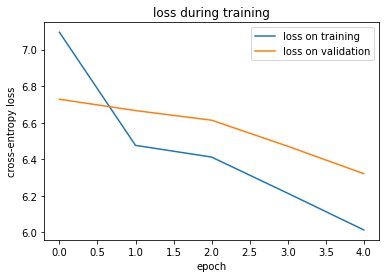

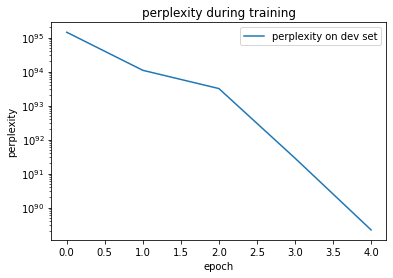

In [ ]:
# Graphs to visualize the training process

from matplotlib import pyplot as plt 


plt.plot(train_loss, label = 'loss on training')
plt.plot(dev_loss, label = 'loss on validation')
plt.title('loss during training')
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')
plt.legend()
plt.show()


plt.plot(dev_pplx, label = 'perplexity on dev set')
plt.yscale('log')
plt.title('perplexity during training')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive') 

%cd /content/gdrive/MyDrive/Master/Machine_Learning_3

# Hyperparameter tuning

In [ ]:
#hyerparameter tuning: 
#TODO: run this 
hidden_sizes = [200, 400, 600]
embedding_sizes = [200, 400, 600]
layer_sizes = [1, 2, 3]

best_hypers = [0, 0, 0]
best_loss = 1000000000

with open('seq2seq_grid_search.csv', 'a') as f: # log file to save grid search results
  f.write(','.join(['hidden size', 'embedding dims', 'num layers', 'training loss', 'validation loss', 'validation perplexity'])+'\n')
  for h_size in hidden_sizes: 
    for emb_size in embedding_sizes: 
      for layer_size in layer_sizes: 

        m = Model(size_vocabulary=len(encoding_map), EOP_id=END_id, 
                  embedding_dim=emb_size, lstm_hidden_size=h_size, lstm_layers=layer_size, device='cuda')
        
        print(f'training model: hidden size {h_size}, embedding dims {emb_size}, num layers {layer_size}')

        t_loss, v_loss, v_pplx = train_model(m, batch_generator, optimizer = torch.optim.Adam(m.parameters()),
                                            epoch_size = len(batch_generator.splits['train']), max_epochs=20, 
                                            batch_size = 256, verbose = False, early_stopping_patience=5)
        
        f.write(','.join(list(map(str,[h_size, emb_size, layer_size, t_loss, v_loss, v_pplx]))))
        f.write('\n')
        
        if v_loss < best_loss: 
          best_loss = v_loss
          print(f'new best hyperparameters: hidden size {h_size}, embedding dims {emb_size}, num layers {layer_size}')
          print('new best loss: ', best_loss, '\n')
          best_hypers = [h_size, emb_size, layer_size]
        

print('best hyperparameters: ', best_hypers)

In [ ]:
prompt = ["Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités."] * 10
batch = batch_generator.turn_into_batch(prompt)
gen_texts = model.predictionStrings(batch.to(model.device), max_predicted_char=1024)

print(prompt[0])
print()
for i, gen_text in enumerate(gen_texts[0]):
  print(f"{i}: ", end="")
  print(gen_text)

# Beam search implementation

In [ ]:
#implement beam search decoding for one sentence at a time 
import numpy as np 

class Beam():
    '''A beam of hypotheses.
    Initialized with the an input paragraph and a trained seq2seq model. contains methods for a full beam search decoding
    of the model outputs.'''

    def __init__(self, model, in_paragraph, beam_size):
        """
        model: the seq2seq model
        in_paragraph: a tensor of shape 1 x sequence length representing a single input paragraph (a batch of size 1)
        beam_size: int
        """
        self.model = model
        self.device = model.device
        self.beam_size = beam_size
        self.closed_hypotheses = [] #to keep track of outputs which have generated the stop token
        self.closed_hypotheses_probs = torch.tensor([]).to(self.device)

        decoder_init_states = model.initStates(in_paragraph)  # a tuple (decoder_init_h, decoder_init_c), each of shape (num_layers x 1 x lstm_hidden_size)

        # creates a 'batch' of size beam_size, all initialized with the same decoder states
        decoder_init_h, decoder_init_c = decoder_init_states  # each should be of shape (num_layers x 1 x lstm_hidden_size) (batch_size = 1)
        decoder_init_h = decoder_init_h.repeat(1, beam_size, 1)   # shape (num_layers x beam_size x lstm_hidden_size)
        decoder_init_c = decoder_init_c.repeat(1, beam_size, 1)   # shape (num_layers x beam_size x lstm_hidden_size)
        self.decoder_init_states = decoder_init_h, decoder_init_c # we will need it at each decoding step (represents encoder output)
        self._full_decoder_init_states = decoder_init_h, decoder_init_c #save this for resizing when we need to change batch size 
        
        # only the last layer is used to compute the distribution for the first token
        init_h_last_layer = decoder_init_h[-1,0,:]  # shape (lstm_hidden_size)

        distributions = self.model.distribution_nn(init_h_last_layer) # shape (vocab_size)
        distributions = torch.nn.functional.softmax(distributions, dim = 0) # shape (vocab_size)

        # chooses the first tokens
        # we sample from the probability distribution to provide more varried hypotheses
        chosen_indices = torch.multinomial(input=distributions, num_samples=beam_size, replacement=False)  # shape beam_size
        chosen_scores = distributions[chosen_indices]  # shape beam_size

        # the probability of each hypothesis in the beam
        # convert to log probabilities so we can sum instead of multiplying probabilities
        self.open_hypotheses_probs = torch.log(chosen_scores).view(-1, 1) #size beam_size x 1 to start, will be smaller as hypotheses are closed

        # contains the first token of each hypothesis 
        self.open_hypotheses = chosen_indices.view(self.beam_size, 1) #size beam size x 1

    def __str__(self): 
        open_strings = ''
        if(len(self.open_hypotheses.squeeze())):
            open_strings = [f"{self.open_hypotheses_probs[i].item()}\t{ids_to_texts([self.open_hypotheses[i]], decoding_map, END_id, word_tokens)[0]}" for i in range(len(self.open_hypotheses))]
        closed_strings = [f"{self.closed_hypotheses_probs[i].item()}\t{ids_to_texts([self.closed_hypotheses[i]], decoding_map, END_id, word_tokens)[0]}" for i in range(len(self.closed_hypotheses))]
        return 'Probs\tOpen hypotheses\n' + "\n".join(open_strings) + '\nProbs\tclosed hypotheses\n' + "\n".join(closed_strings)+'\n'

    def _resize_init_states(self): 
        #helper function to make sure the init states for the model match the shape of the open hypotheses in the beam 
        decoder_init_h, decoder_init_c = self._full_decoder_init_states  # init states from last decoding step, size num_layers x open_size x lstm_hidden_size 
        decoder_init_h = decoder_init_h[:, :len(self.open_hypotheses), :].contiguous()  # shape (num_layers x open_size x lstm_hidden_size)
        decoder_init_c = decoder_init_c[:, :len(self.open_hypotheses), :].contiguous()  # shape (num_layers x open_size x lstm_hidden_size)
        self.decoder_init_states = decoder_init_h, decoder_init_c #

    def _decode_step(self, verbose = True):
        """
        computes probabilites for continuation character for each hypothesis in the beam, then select the 
        K most likely sequences, and update hypotheses and probabilities 
        """
        with torch.no_grad():
            char_embeds                 = self.model.char_embeddings(self.open_hypotheses) # num_open_hyp x seq_length (current decoding step) x embedding_size 
            self._resize_init_states()
            decoder_output, _           = self.model.decoder_lstm(char_embeds, self.decoder_init_states) # open_hyps x seq_length x hidden size 
            decoder_output              = decoder_output[:,-1, :] # open_hyps x hidden_size (we keep only the last token representation)
            char_distributions          = self.model.distribution_nn(decoder_output) # open_hyps x vocab_size

            # adds probabilities of the hypotheses so far to probabilities for the next token
            char_distributions          = torch.nn.functional.log_softmax(char_distributions, dim = 1) #open_hyps x vocab size 
            scores                      = char_distributions + self.open_hypotheses_probs #open_hyps x vocab size 
            # turn log probs back into probs for multinomial 
            scores                      = torch.exp(scores).flatten() # shape open_hypothese * vocab_size
            #concatinate with the probabilities for closed hypotheses in the beam
            scores                      = torch.cat([scores, torch.exp(self.closed_hypotheses_probs.flatten())]) #beam_size*vocab_size

            # sample k scores based off their probabilities
            chosen_indices              = torch.multinomial(input=scores, num_samples=self.beam_size, replacement=False)  # shape beam_size

            #seperate scores and indices for open vs closed hypotheses 
            open_chosen_indices         = chosen_indices[(chosen_indices<len(self.open_hypotheses)*self.model.size_vocabulary)] #num_open 
            closed_chosen_indices       = chosen_indices[(chosen_indices>=len(self.open_hypotheses)*self.model.size_vocabulary)] #num_closed
            closed_chosen_indices       -= len(self.open_hypotheses)*self.model.size_vocabulary #num_closed

            #get closed hypothese and probs which are kept
            self.closed_hypotheses        = np.take(self.closed_hypotheses, closed_chosen_indices.tolist(), axis=0).tolist()
            self.closed_hypotheses_probs  = self.closed_hypotheses_probs[closed_chosen_indices]

            #for open hypothese and scores, we compute the next char and add probabilities 
            # tensor of shape beam_size containing the id of every selected token to continuate the hypotheses
            open_token_continuations      = open_chosen_indices % self.model.size_vocabulary #shape num_open_hypotheses
            # tensor of shape beam_size containing the id of every hypothesis selected to be continuated
            open_hypotheses_continuations = torch.div(open_chosen_indices, self.model.size_vocabulary).int() #shape num_open_hypotheses

            # updates the openhypotheses' scores
            open_hypotheses_probs         = torch.log(scores[open_chosen_indices]).view(-1, 1)  # change back to logs so we can sum instead of multiplying

            # updates the hypotheses with newly generated chars 
            continued_hypotheses          = self.open_hypotheses[open_hypotheses_continuations.long()] 
            continued_hypotheses          = torch.cat([continued_hypotheses, open_token_continuations.view(-1, 1)], dim = 1)  # adds the selected token to each hyp
            
            #mask for newly closed elements anad split into open and newly closed hypotheses
            newly_closed_mask             = (open_token_continuations == self.model.EOP_id).view(-1) #size open_hypotheses
            self.open_hypotheses          = continued_hypotheses[(newly_closed_mask==False)]  #size new open_hypotheses
            self.open_hypotheses_probs    = open_hypotheses_probs[(newly_closed_mask==False)]#size new open_hypotheses


            newly_closed_hypotheses = continued_hypotheses[newly_closed_mask] #number of newly closed hypotheses
            newly_closed_probs = open_hypotheses_probs[newly_closed_mask].view(-1) 
            
            self.closed_hypotheses.extend(newly_closed_hypotheses.tolist())
            self.closed_hypotheses_probs = torch.cat([self.closed_hypotheses_probs, newly_closed_probs])

        if verbose: print(str(self))


    def decode(self, max_paragraph_length, verbose = True): 
        '''
        Decodes a paragraph, outputs the best hypothesis found using beam search.
        max_paragraph_length: int
        '''
        for i in range(max_paragraph_length):
            self._decode_step(verbose)

            # If all hypotheses contain EOP, stop
            if len(self.open_hypotheses)==0: 
              break
        #if no sequences were closed, output the best open sequence 
        if len(self.closed_hypotheses) == 0 : #there are no closed hypotheses
          return self.open_hypotheses[torch.argmax(self.open_hypotheses_probs)]
        #otherwise, output the best closed hypothesis
        return self.closed_hypotheses[torch.argmax(self.closed_hypotheses_probs)]     

In [ ]:
beam_size = 5

#get an example sentence
batch = batch_generator.get_batch(1)
print(ids_to_texts(batch[0], decoding_map, END_id, word_tokens=word_tokens))

beam = Beam(model, batch[0].to(model.device), beam_size)
out_paragraph = beam.decode(50, verbose = True)
len(out_paragraph)

print(ids_to_texts([out_paragraph], decoding_map, END_id, word_tokens=word_tokens))

In [ ]:
print(str(beam))

Read the remarks at the beginning of the TP again.

Once you are sure that your system is correctly implemented and generates texts that look a little bit like natural language, find ways to improve the system.
Here are some ideas (ordered arbitrarily):

*   Compute a measure that evaluates the performance of the model.
*   Split your dataset into a training and a development section, and use this split in a relevant way.
*   Implement beam decoding instead of greedy decoding.
*   Use other units of text instead of characters (ex: words, word-pieces).
*   Add more data to the dataset.
*   Use graphs to visualise the training process and the predictions.

Document in a text cell all of the changes that you make to the system and describe their impact.

# Discussion of our improvements

**evaluating models:**
To evaluate models, we use both cross-entropy loss and a perplexity score. To calculate these, first we split our data into training, validation, and test splits. During training, cross-entropy loss is calculated on the training and validation splits (and used for early stopping), while perplexity is calculated on the validation split. We define perplexity as the sum of the inverse log probabilities for each sentence in the validation split. As shown in the graphs after training, these two measures roughly correlate with eachother. 

**tokenization strategies:**
we implement two dokenization strategies: a character-by-character one and a word-level one using polyglot as the tokenizer. this can be controlled by a variable "TOKENIZATION" in the first code window. Word-level tokenization has the advantage of ensuring that outputs will at least be real words, but struggles with unknown words in the dev and test sets, and also can only output words seen in training. character-level tokenization on the other had produces outputs full of spelling errors, but does not have the same vocabulary issue. 



**beam search:**
Observationally, adding beam search decoding makes the model's outputs resemble natural language much more closely. with raw outputs, there are frequent misspellings even for well-trained models, however with beam search spelling is overall much better. Additionally, punctuation patterns are much more consistent and gramatical. 

**limitations:** in our implementation of beam search, there is no normalization for hypothesis lengths. this means that as hypotheses get longer, the probabilities naturally get lower. this has two unwanted effects: 


1.   Shorter hypotheses are preferred. this means that the first hypothesis to generate the stop token will almost always be the one selected. 
2.   for poorly trained models, they may arrive at a situation where the the probabilites for all continuations are too low to select, resulting in a crash. this is more likely for models which have not been trained enough, and is also more likley when using character tokenization (as character sequences are longer than word sequences). If this happens, consider retraining the model or decreasing the maximum output length. 

Additionally, the model has a limited sensitivity to the input paragraph: it can capture some information about the input paragraph but without any detail. 

